# SILVA-CRAS SEPPO

# Capitulo 4 - Series de tiempo SAR análisis sitios de cambio


Josef Kellndorfer, Ph.D., President and Senior Scientist, Earth Big Data, LLC

Carlos Pedraza, Ms.C., Spatial analyst and Monitoring Expert, iScioLab and Earth Big Data, LLC

Fecha revisión: Pendiente

En este capítulo presentamos los conceptos avanzados de detección de puntos de cambio en series temporales. Uno de los objetivos de la detección de cambios, en particular para las aplicaciones forestales, es rastrear con la identificación de perturbaciones a lo largo de un período de observación, así como el momento en que se producen los eventos. Muchas herramientas para la detección de puntos de cambio provienen del sector financiero y están disponibles hoy en día con diferentes complejidades. En este libro de trabajo analizaremos las firmas de series de tiempo de SAR con énfasis en las series de tiempo del bosque en los datos de ejercicio y capacitación. Comenzaremos explorando series de tiempo a nivel de píxeles y trabajaremos hasta un escenario de detección de puntos de cambio con un análisis basado en imágenes.

In [36]:
# Importing relevant python packages
import pandas as pd
import gdal
import ogr,osr
import numpy as np
import time,os

# For plotting
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.patches as patches

font = {'family' : 'monospace',
          'weight' : 'bold',
          'size'   : 13}
plt.rc('font',**font)

### Helper function the generate a time series object

In [37]:
def timeSeries(rasterstack_pwr,tindex,subset,ndv=0.):
    # Extract the means along the time series axes
    # raster shape is time steps, lines, pixels. 
    # With axis=1,2, we average lines and pixels for each time 
    # step (axis 0)
    raster=rasterstack_pwr.copy()
    if ndv != np.nan: raster[np.equal(raster,ndv)]=np.nan
    ts_pwr=np.nanmean(raster[:,subset[1]:(subset[1]+subset[3]),
                       subset[0]:(subset[0]+subset[2])],axis=(1,2))
    # convert the means to dB
    ts_dB=10.*np.log10(ts_pwr)
    # make the pandas time series object
    ts = pd.Series(ts_dB,index=tindex)
    # return it
    return ts

# Set Project Directory and Filenames


In [38]:
#############################################################
# Image data
#############################################################
datapath='/Users/amenaza/github/Silva-Cras-PatNat/Data/Colombia/S32718X350000Y9353000sS1_EBD/'
datefile_like='S32718X350000Y9323000sS1_D_vv_0069_mtfil.dates'
datefile_cross='S32718X350000Y9323000sS1_D_vh_0069_mtfil.dates'
imagefile_like='S32718X350000Y9323000sS1_D_vv_0069_mtfil.vrt'
imagefile_cross='S32718X350000Y9323000sS1_D_vh_0069_mtfil.vrt'
## Select the like-polarized or cross-polarized image and dates file
imagefile=imagefile_cross
datefile=datefile_cross
## Set Title for figures
flightdirection_polarization='Sentinel-1, Descending C-VH Data'

#############################################################
# Set Shapefile (sf) with reference data points (ref_data)
#############################################################
sf='/Users/amenaza/github/Silva-Cras-PatNat/Data/Colombia/vector/Validation_Shapefile/Validation_Forest_NonForest_Final.shp'

#############################################################
# Switch to the data directory 
# If ERROR: Check your datapath and sf
#############################################################
os.chdir(os.path.join(datapath))

## Acquisition Dates

Read from the Dates file the dates in the time series and make a pandas date index

In [39]:
dates=open(datefile).readlines()
tindex=pd.DatetimeIndex(dates)
j=1
print('Bands and dates for',imagefile)
for i in tindex:
    print("{:4d} {}".format(j, i.date()),end=' ')
    j+=1
    if j%5==1: print()

Bands and dates for S32718X350000Y9323000sS1_D_vh_0069_mtfil.vrt
   1 2017-01-09    2 2017-02-02    3 2017-02-26    4 2017-03-10    5 2017-04-03 
   6 2017-04-15    7 2017-04-27    8 2017-05-09    9 2017-05-21   10 2017-06-02 
  11 2017-06-14   12 2017-06-26   13 2017-07-08   14 2017-07-20   15 2017-08-01 
  16 2017-08-13   17 2017-08-25   18 2017-09-06   19 2017-09-18   20 2017-09-30 
  21 2017-10-12   22 2017-10-24   23 2017-11-05   24 2017-11-17   25 2017-11-29 
  26 2017-12-11   27 2017-12-23   28 2018-01-04   29 2018-01-16   30 2018-01-28 
  31 2018-02-09   32 2018-02-21   33 2018-03-05   34 2018-03-17   35 2018-03-29 
  36 2018-04-10   37 2018-04-22   38 2018-05-04   39 2018-05-16   40 2018-05-28 
  41 2018-06-09   42 2018-10-31   43 2018-11-12   44 2018-11-24   45 2018-12-06 
  46 2018-12-18   47 2018-12-30   48 2019-01-11   49 2019-01-23   50 2019-02-04 
  51 2019-02-16   52 2019-03-12   53 2019-03-24   54 2019-04-17   55 2019-04-29 
  56 2019-05-11   57 2019-05-23   58 2019-05

## Define a subset of the image data stack based on reference data

We will use a shapefile of clustered reference points to define the extent of a subset we are interested in. To that end we will read all points in a shapefile, convert the coordinates (if needed) from Lon/Lat to the projection of the Image file, compute the maximum extent and buffer it. 

### 1. Read reference points layer, get its extent, and determine the corner coordinates of the bounding box (upper left, upper right, lower left, lower right)

In [40]:
ref_data = ogr.Open(sf)
layer=ref_data.GetLayer()

In [41]:
x1,x2,y1,y2=layer.GetExtent()
x=(x1,x2)
y=(y1,y2)
print(x,y)

(-76.32933899848146, -76.1352478472336) (-6.053846610645197, -5.856311305389244)


In [42]:
ul=(min(x),max(y))
ur=(max(x),max(y))
ll=(min(x),min(y))
lr=(min(x),min(y))

### 2. Transform the coordinates to the coordinate system of the image

We will read the spatial reference system of the source (point layer file - ssrs) and the target (image - tsrs). With this information we can generate a transform function to project the points into the image reference system.

In [43]:
ssrs = layer.GetSpatialRef()
print('Points\n',ssrs.ExportToPrettyWkt())

Points
 GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AXIS["Latitude",NORTH],
    AXIS["Longitude",EAST],
    AUTHORITY["EPSG","4326"]]


In [44]:
img_handle=gdal.Open(imagefile)
proj=img_handle.GetProjection()
geotrans=img_handle.GetGeoTransform()
tsrs=osr.SpatialReference(proj)
print('Image\n',tsrs.ExportToPrettyWkt())

Image
 PROJCS["WGS 84 / UTM zone 18S",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-75],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",10000000],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32718"]]


In [45]:
# Generate the transform function from the osr module
transform=osr.CreateCoordinateTransformation(ssrs,tsrs)

To get the coordinates of a feature point in the reference data set layer we can use the geometry attribute of a point. For example for the first point the coordinates are:

In [46]:
# Here is how we get the coordinates of a point
pt = layer.GetFeature(0)
ptg = pt.geometry()
ptg.GetPoint()

(-76.21934877792668, -5.991501492342234, 0.0)

Now we can loop over the points in the layer and transform them to UTM coordinates.
We will store the results in a dictionary that we can use later to look at the points. What fields are in the reference point file?


In [47]:
ref_points={}
for i in range(layer.GetFeatureCount()):
    ref_point={}
    pt=layer.GetFeature(i)
    FID=pt.GetFID()
    ref_point['Feature']=pt
    ref_point['XY']=transform.TransformPoint(*pt.geometry().GetPoint())[:2]
    ref_points[FID]=ref_point


In [48]:
keys= ref_points[0]['Feature'].keys()
keys

['YY_Change', 'ID', 'Date_Befor', 'Date_After']

Let's list all the points with their UTM coordinates and attributes:


In [49]:
for fid in ref_points:
    coords=ref_points[fid]['XY']
    attributes='\t'.join([ref_points[fid]['Feature'][x] for x in ['ID', 'Date_Befor', 'Date_After','YY_Change']])
    print('{:.1f} {:.1f} {}'.format(*coords,attributes))

365043.2 9337585.0 P-1	2019/07/11	2019/07/21	2018 - 2019
359328.7 9341057.5 P-2	2019/08/02	2019/08/05	2017 - 2019
353634.2 9346299.2 P-3	2019/06/20	2019/08/06	2017 - 2019
359755.5 9344536.7 P-4	2019/04/15	2019/05/02	2017 - 2019
374363.1 9332626.5 P-5	2019/05/28	2019/06/06	2018 - 2019
357533.8 9337191.4 P-6	2019/08/30	2019/09/05	2017 - 2019
357764.0 9337340.9 P-7	2017/10/18	2017/10/31	2017 - 2019
364409.9 9339473.2 P-8	2019/07/11	2019/07/21	2017 - 2019
364613.6 9339172.9 P-9	2019/06/15	2019/06/20	2017 - 2019
373462.6 9336410.6 P-10	2019/06/13	2019/06/15	2018 - 2019
373291.6 9330709.6 P-11	2019/07/21	2019/07/30	2018 - 2019
372686.6 9335101.7 P-12	2019/05/30	2019/06/06	2018 - 2019
373499.4 9334949.3 P-13	2019/07/10	2019/08/31	2018 - 2019
373355.5 9334623.3 P-14	2019/07/11	2019/07/21	2018 - 2019
367724.3 9338021.6 P-15	2019/07/31	2019/08/05	2018 - 2019
366245.1 9335578.5 P-16	2019/07/10	2019/07/21	2018 - 2019
353700.5 9333248.8 P-17	2019/08/13	2019/09/02	2017 - 2019
352879.3 9332723.9 P-18

### 3. Convert the bounding box coordinates to raster coordinates

We use the geotransformation information from the image file to convert the UTM coordinates. The gdal geotrans is organized as 
x offset, x resolution, X height, Y offset, Y resolution, height

We can compute the raster coordinates as

$X_{raster} = (X_{projected} - X_{offset})/X_{resolution}$

$Y_{raster} = (Y_{projected} - Y_{offset})/Y_{resolution}$

Let's define a function to do the projected to raster coordinate transformation. We will allow for a buffer to be added.

We will also round and convert to integer the raster pixel,line coordinates.

In [50]:

def XY_to_PixelLine(X_projected,Y_projected,geotrans,buffer_x=0,buffer_y=0):
    X_offset,X_resolution,_,Y_offset,_,Y_resolution=geotrans
    X_raster = (X_projected - X_offset+buffer_x)/X_resolution
    Y_raster = (Y_projected - Y_offset-buffer_x)/Y_resolution
    return int(round(X_raster)),int(round(Y_raster))


Let's test the function on the reference data extent that we determine from our UTM coordinates for all points:

In [51]:
# Find the minimum and maximum X and Y coordinates of the boundoung box
minX=min([ref_points[fid]['XY'][0] for fid in ref_points])
maxX=max([ref_points[fid]['XY'][0] for fid in ref_points])
minY=min([ref_points[fid]['XY'][1] for fid in ref_points])
maxY=max([ref_points[fid]['XY'][1] for fid in ref_points])
print('Reference Dataset Extent:\nminX,maxX,minY,maxY\n{:.1f} {:.1f} {:.1f} {:.1f}'.format(minX,maxX,minY,maxY))

Reference Dataset Extent:
minX,maxX,minY,maxY
352879.3 374363.1 9330709.6 9352529.1


min X, max Y in raster coordinates (referred to as xoff,yoff in gdal programs)

In [52]:
XY_to_PixelLine(minX,maxY,geotrans)

(144, 24)

... and buffered by 100 m to the east and north (at 20 m pixel spacing this should be 5 pixels)

In [53]:
XY_to_PixelLine(minX,maxY,geotrans,-100,100)

(139, 19)

### 4. Get the subset in raster coordinates to extract from the image stack

In [54]:
pixels,lines=img_handle.RasterXSize,img_handle.RasterYSize
ulx,uly=XY_to_PixelLine(minX,maxY,geotrans,-100,100)
lrx,lry=XY_to_PixelLine(maxX,minY,geotrans,100,-100)
xsize=lrx-ulx
ysize=lry-uly
# Check some boundaries:
if ulx < 0: ulx=0
if uly < 0: uly=0
if ulx+xsize> pixels: xsize=pixels-xsize
if uly+ysize> lines: ysize=lines-ysize

subset=ulx,uly,xsize,ysize
print('Determined xoff,yoff,xsize,ysize: ',subset)

Determined xoff,yoff,xsize,ysize:  (139, 19, 1084, 1101)


## Transform the point locations to pixel/line locations in the subset

We will use the geotranformation to get all coordinates of the referece data in UTM coordinates and pixel line coordinates in the subset.

In [55]:
# Now we can loop over the points in the layer and transform them to UTM and pixel line coordinates.
# We will store the results in a dictionary that we can use later to look at the points
print('ID PID  Easting  Northing     P    L    YEAR            PID     Before Date     After Date\n')
for fid in ref_points:
#     pt=layer.GetFeature(i)
    xy = ref_points[fid]['XY']
    pl = XY_to_PixelLine(xy[0],xy[1],geotrans)
    X= pl[0]-ulx
    Y = pl[1]-uly
    ref_points[fid]['PL']=[X,Y]

    print('{:2d} {:4s} {:.1f} {:.1f} {:4d} {:4d} {}'.format(fid,ref_points[fid]['Feature']['ID'],*xy,X,Y,\
          '\t'.join([ref_points[fid]['Feature'][x] for x in ref_points[fid]['Feature'].keys()])))

ID PID  Easting  Northing     P    L    YEAR            PID     Before Date     After Date

 0 P-1  365043.2 9337585.0  613  752 2018 - 2019	P-1	2019/07/11	2019/07/21
 1 P-2  359328.7 9341057.5  327  578 2017 - 2019	P-2	2019/08/02	2019/08/05
 2 P-3  353634.2 9346299.2   43  316 2017 - 2019	P-3	2019/06/20	2019/08/06
 3 P-4  359755.5 9344536.7  349  404 2017 - 2019	P-4	2019/04/15	2019/05/02
 4 P-5  374363.1 9332626.5 1079 1000 2018 - 2019	P-5	2019/05/28	2019/06/06
 5 P-6  357533.8 9337191.4  238  771 2017 - 2019	P-6	2019/08/30	2019/09/05
 6 P-7  357764.0 9337340.9  249  764 2017 - 2019	P-7	2017/10/18	2017/10/31
 7 P-8  364409.9 9339473.2  581  657 2017 - 2019	P-8	2019/07/11	2019/07/21
 8 P-9  364613.6 9339172.9  592  672 2017 - 2019	P-9	2019/06/15	2019/06/20
 9 P-10 373462.6 9336410.6 1034  810 2018 - 2019	P-10	2019/06/13	2019/06/15
10 P-11 373291.6 9330709.6 1026 1096 2018 - 2019	P-11	2019/07/21	2019/07/30
11 P-12 372686.6 9335101.7  995  876 2018 - 2019	P-12	2019/05/30	2019/06/06
12 P-

## Image data
Get the time series raster stack from the entire training data set for the subset.

In [56]:
rasterstack=gdal.Open(imagefile).ReadAsArray(*subset)
rasterstack[rasterstack==0]=1   
# Typically we treat nodata separately. For simplitcity we set 0 to 1 here 
#(to avooid log10(0) for dB conversion)

# Data Pre-Processing 
## Plot the global means of the Time Series 
1. conversion to power
2. compute means
3. convert to dB
4. make a pandas time series 
5. plot time series of means


In [57]:
# 1. Conversion to Power
caldB=-83
calPwr = np.power(10.,caldB/10.)
rasterstack_pwr = np.power(rasterstack,2.)*calPwr
# 2. Compute Means
rs_means_pwr = np.mean(rasterstack_pwr,axis=(1,2))
# 3. Convert to dB
rs_means_dB = 10.*np.log10(rs_means_pwr)

In [58]:
# 4. Make a pandas time series object
ts = pd.Series(rs_means_dB,index=tindex)

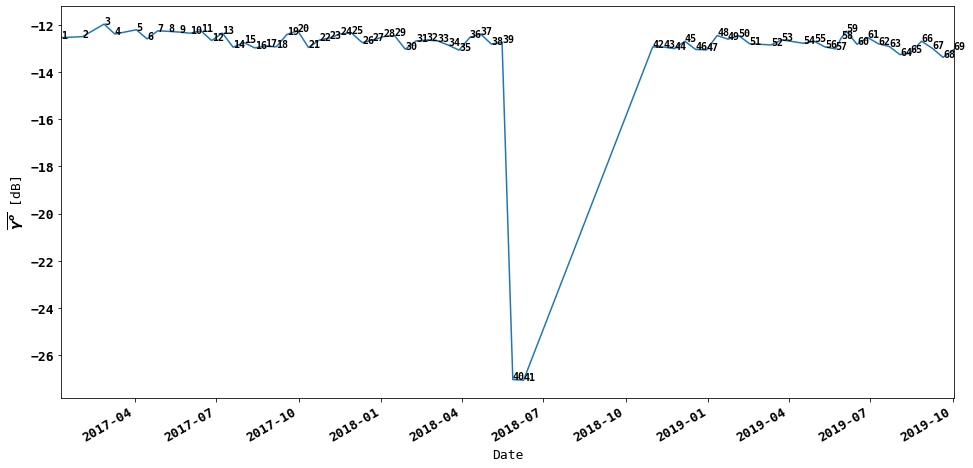

In [59]:
# 5. Use the pandas plot function of the time series object to plot
# Put band numbers as data point labels
plt.figure(figsize=(16,8))
ts.plot()
xl = plt.xlabel('Date')
yl = plt.ylabel('$\overline{\gamma^o}$ [dB]')
for xyb in zip(ts.index,rs_means_dB,range(1,len(ts)+1)):
    plt.annotate(xyb[2],xy=xyb[0:2],size=10)


Let's elimiate band 40 and 41 from the data stack and tindex.

In [60]:
tindex2 = tindex.drop([tindex[40],tindex[41]])
rasterstack2 = np.vstack((rasterstack[:39],rasterstack[41:]))
rasterstack_pwr = np.power(rasterstack2,2.)*calPwr
# 2. Compute Means
rs_means_pwr = np.mean(rasterstack_pwr,axis=(1,2))
# 3. Convert to dB
rs_means_dB = 10.*np.log10(rs_means_pwr)
ts2 = pd.Series(rs_means_dB,index=tindex2)

Now let's plot again:

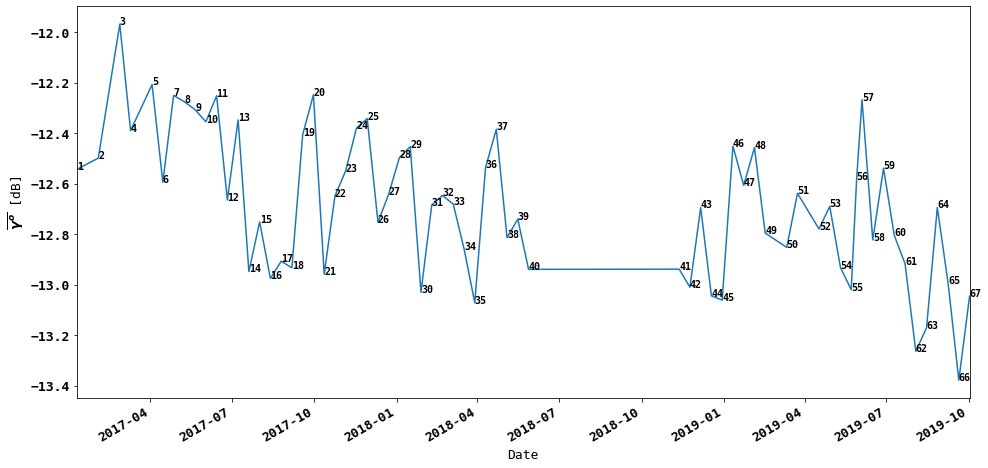

In [61]:
plt.figure(figsize=(16,8))
ts2.plot()
xl = plt.xlabel('Date')
yl = plt.ylabel('$\overline{\gamma^o}$ [dB]')
for xyb in zip(ts2.index,rs_means_dB,range(1,len(ts)+1)):
    plt.annotate(xyb[2],xy=xyb[0:2],size=10)



In [62]:
print('Bands and dates for pruned',imagefile)
j=1
for i in tindex2:
    print("{:4d} {}".format(j, i.date()),end=' ')
    j+=1
    if j%5==1: print()

Bands and dates for pruned S32718X350000Y9323000sS1_D_vh_0069_mtfil.vrt
   1 2017-01-09    2 2017-02-02    3 2017-02-26    4 2017-03-10    5 2017-04-03 
   6 2017-04-15    7 2017-04-27    8 2017-05-09    9 2017-05-21   10 2017-06-02 
  11 2017-06-14   12 2017-06-26   13 2017-07-08   14 2017-07-20   15 2017-08-01 
  16 2017-08-13   17 2017-08-25   18 2017-09-06   19 2017-09-18   20 2017-09-30 
  21 2017-10-12   22 2017-10-24   23 2017-11-05   24 2017-11-17   25 2017-11-29 
  26 2017-12-11   27 2017-12-23   28 2018-01-04   29 2018-01-16   30 2018-01-28 
  31 2018-02-09   32 2018-02-21   33 2018-03-05   34 2018-03-17   35 2018-03-29 
  36 2018-04-10   37 2018-04-22   38 2018-05-04   39 2018-05-16   40 2018-05-28 
  41 2018-11-12   42 2018-11-24   43 2018-12-06   44 2018-12-18   45 2018-12-30 
  46 2019-01-11   47 2019-01-23   48 2019-02-04   49 2019-02-16   50 2019-03-12 
  51 2019-03-24   52 2019-04-17   53 2019-04-29   54 2019-05-11   55 2019-05-23 
  56 2019-05-29   57 2019-06-04   58 

## EXERCISE
Look at the global means plot and determine from the tindex array at which dates you see  maximum and minimum values. Are relative peaks associated with seasons?

# Generate Time Series for  Point Locations or Subsets 

In python we can use the matrix slicing rules (Like Matlab) to obtain subsets of the data. For example to pick one pixel at a line/pixel location and obtain all band values, use:

>  [:,line,pixel] notation. 

Or, if we are interested in a subset at a offset location we can use:

> [:,yoffset:(yoffset+yrange),xoffset:(xoffset+xrange)]

In the section below we will learn how to generate time series plots for point locations (pixels) or areas (e.g. a 5x5 window region). To show  individual bands, we define get_subset and showImage functions which incorporates the matrix slicing from above.

In [63]:
def get_subset(fid,ref_points,windowsize=3):
    pl=ref_points[fid]['PL']
    buffer=int(windowsize/2)
    return [pl[0]-buffer,pl[1]-buffer,windowsize,windowsize]
    
    

In [64]:
def showImage(rasterstack,tindex,bandnbr,subset=None,vmin=None,vmax=None,ylim=(-20,-5),title='',zoom=False):
    '''Input: 
    rasterstack stack of images in SAR power units
    tindex time series date index
    bandnbr bandnumber of the rasterstack to dissplay'''
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    # If vmin or vmax are None we use percentiles as limits:
    if vmin==None: vmin=np.percentile(rasterstack[bandnbr-1].flatten(),5)
    if vmax==None: vmax=np.percentile(rasterstack[bandnbr-1].flatten(),95)

    if zoom and subset !=None:
            ax1.imshow(rasterstack[bandnbr-1,subset[1]:(subset[1]+subset[3]),
                       subset[0]:(subset[0]+subset[2])],cmap='gray',vmin=vmin,vmax=vmax,interpolation='bilinear')
    else:
        ax1.imshow(rasterstack[bandnbr-1],cmap='gray',vmin=vmin,vmax=vmax,interpolation='bilinear')

    ax1.set_title('Time Series Band {} {}'.format(bandnbr,tindex[bandnbr-1].date()))
    if subset!= None:
        ax1.add_patch(patches.Rectangle((subset[0],subset[1]),subset[2],subset[3],fill=False,edgecolor='red'))
    else:
        bands,ydim,xdim=rasterstack.shape
        subset=(0,0,xdim,ydim)

        ax1.xaxis.set_label_text('Pixel')
    ax1.yaxis.set_label_text('Line')
    
    ts_pwr=np.mean(rasterstack[:,subset[1]:(subset[1]+subset[3]),
                       subset[0]:(subset[0]+subset[2])],axis=(1,2))
    ts_dB=10.*np.log10(ts_pwr)
    ax2.plot(tindex,ts_dB)
    ax2.set_ylim(ylim)
    ax2.yaxis.set_label_text('$\gamma^o$ [dB]')
    ax2.set_title(title+' $\gamma^o$ Backscatter Time Series')
    # Add a vertical line for the date where the image is displayed
    ax2.axvline(tindex[bandnbr-1],color='red')

    fig.autofmt_xdate()

Let's use the *showImage* function to display band 62, the time series mean of the subset and where that mean of band 62 shows in the time series. If subset is set to None, the  mean of each of the entire bands is computed.

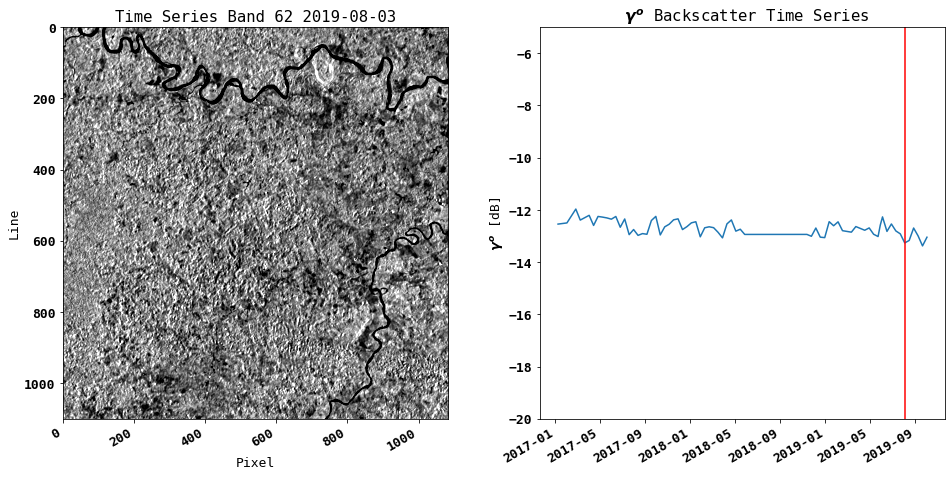

In [65]:
subset=None
bandnbr=62
showImage(rasterstack_pwr,tindex2,bandnbr,subset=subset,zoom=False)

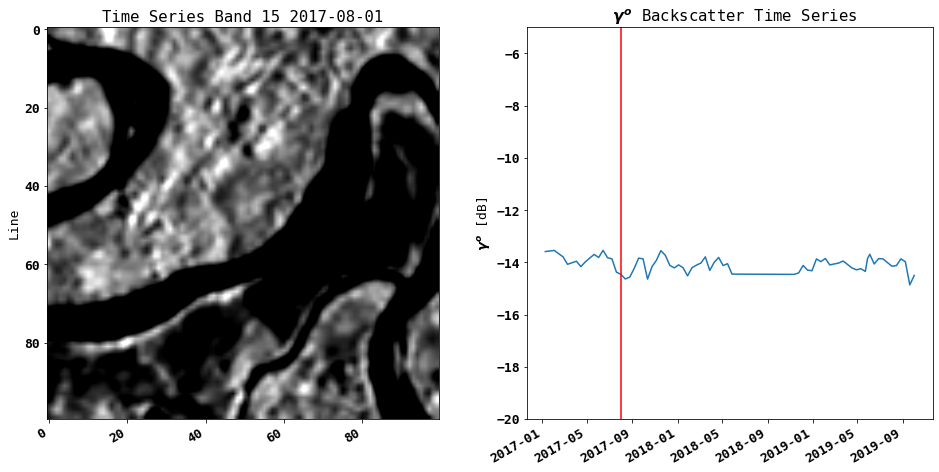

In [66]:
subset=(300,100,100,100)
bandnbr=15
showImage(rasterstack_pwr,tindex2,bandnbr,subset=subset,zoom=True)

## Plots for all time series
We are interested in looking at all the time series from the reference plots


In [67]:
# WE REPEAT OUR BAND AND POINT OUTPUT AS A REFERNCE
print('Bands and dates for pruned',imagefile)
j=1
for i in tindex2:
    print("{:4d} {}".format(j, i.date()),end=' ')
    j+=1
    if j%5==1: print()
        
print('\n\nFID PID  Easting  Northing     P    L    YEAR            PID     BeforeDate      After Date\n')
for fid in ref_points:
#     pt=layer.GetFeature(i)
    xy = ref_points[fid]['XY']
    pl = XY_to_PixelLine(xy[0],xy[1],geotrans)
    X= pl[0]-ulx
    Y = pl[1]-uly
    ref_points[fid]['PL']=[X,Y]

    print('{:2d} {:4s} {:.1f} {:.1f} {:4d} {:4d} {}'.format(fid,ref_points[fid]['Feature']['ID'],*xy,X,Y,\
          '\t'.join([ref_points[fid]['Feature'][x] for x in ref_points[fid]['Feature'].keys()])))

Bands and dates for pruned S32718X350000Y9323000sS1_D_vh_0069_mtfil.vrt
   1 2017-01-09    2 2017-02-02    3 2017-02-26    4 2017-03-10    5 2017-04-03 
   6 2017-04-15    7 2017-04-27    8 2017-05-09    9 2017-05-21   10 2017-06-02 
  11 2017-06-14   12 2017-06-26   13 2017-07-08   14 2017-07-20   15 2017-08-01 
  16 2017-08-13   17 2017-08-25   18 2017-09-06   19 2017-09-18   20 2017-09-30 
  21 2017-10-12   22 2017-10-24   23 2017-11-05   24 2017-11-17   25 2017-11-29 
  26 2017-12-11   27 2017-12-23   28 2018-01-04   29 2018-01-16   30 2018-01-28 
  31 2018-02-09   32 2018-02-21   33 2018-03-05   34 2018-03-17   35 2018-03-29 
  36 2018-04-10   37 2018-04-22   38 2018-05-04   39 2018-05-16   40 2018-05-28 
  41 2018-11-12   42 2018-11-24   43 2018-12-06   44 2018-12-18   45 2018-12-30 
  46 2019-01-11   47 2019-01-23   48 2019-02-04   49 2019-02-16   50 2019-03-12 
  51 2019-03-24   52 2019-04-17   53 2019-04-29   54 2019-05-11   55 2019-05-23 
  56 2019-05-29   57 2019-06-04   58 

Now we loop over all the FIDs an plot the backscatter time series. First we will generate a list that contains the pairs of before and after change dates from the reference points file. We will use this list to plot vertical lines indicating where the reference points suggest the change happended.

In [68]:
# We make use of the python datetime modue
import datetime as dt   
before_after_dates=[]
for i in range(len(ref_points)):    
    before = dt.datetime.strptime(ref_points[i]['Feature'].GetField(2),"%Y/%m/%d")
    after  = dt.datetime.strptime(ref_points[i]['Feature'].GetField(3),"%Y/%m/%d")
    before_after_dates.append([before,after])


Now let's plot the time series for each point, with the vertical lines of the claimed change period, and a horizontal line of the mean backscatter as a reference.

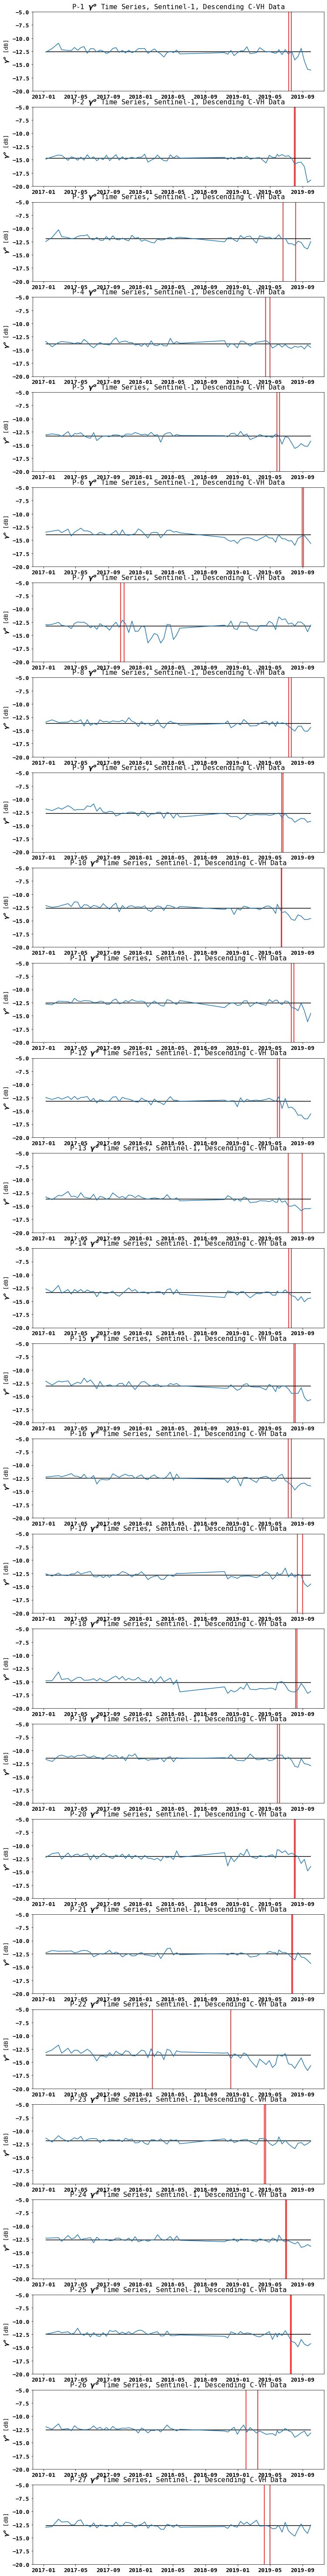

In [69]:
ylim=(-20,-5)
fig,ax=plt.subplots(len(ref_points),1,figsize=(12,len(ref_points)*4))
for fid in range(len(ref_points)):
    subset=get_subset(fid,ref_points,windowsize=3)
    ts_pwr=np.mean(rasterstack_pwr[:,subset[1]:(subset[1]+subset[3]),
                       subset[0]:(subset[0]+subset[2])],axis=(1,2))
    ts_dB=10.*np.log10(ts_pwr)
    ax[fid].plot(tindex2,ts_dB)
    ax[fid].vlines(before_after_dates[fid], 0, 1, transform=ax[fid].get_xaxis_transform(), colors='r')
    ax[fid].hlines(10*np.log10(ts_pwr.mean()), min(tindex2),max(tindex2),colors='black')
#     ax[fid].hlines(ts_dB.mean(), min(tindex2),max(tindex2),colors='gray')
    ax[fid].set_ylim(ylim)
    ax[fid].yaxis.set_label_text('$\gamma^o$ [dB]')
    ax[fid].set_title('P-'+str(fid+1)+' $\gamma^o$ Time Series, '+ flightdirection_polarization)

### EXERCISE
Look at the time series and observe backscatter trends before and after the changes. 
- Can you determine a general trend of lowered backscatter after logging disturbance? 
- What is the time lag for change to become obvious in the Sentinel-1 Time Series?
- Are there points where the change is not obvious? What could be the reason for this?

## Seasonal Subsets of time series records
Let's expand upon SAR time series analysis. Often it is desirable to subset time series by season or months to compare with similar conditions of a previous year's observation. For example, in analyzing C-Band backscatter data, it might be useful to limit comparative analysis to dry season observations only as soil moisture might confuse signals during the wet seasons. In this section we will expand upon the concepts of subsetting time series along the time axis. We will make use of the pandas datatime index tools

- month
- day of year 

First we extract the time series again for a hectare the pixel at Point 12 with a 3x3 buffer. We then convert the pandas time series to a pandas DataFrame to allow for more processing options. We also label the data value column as 'g0' for gamma0.


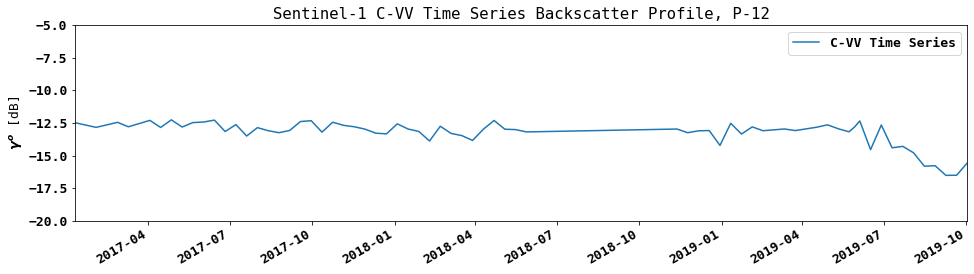

In [70]:
ref_point=12
fid=ref_point-1 # Python starts counting feature id's at 0!
subset=get_subset(fid,ref_points,windowsize=3)

ts = timeSeries(rasterstack_pwr,tindex2,subset)
tsdf = pd.DataFrame(ts,index=ts.index,columns=['g0'])

# Plot
ylim=(-20,-5)
tsdf.plot(figsize=(16,4))
plt.title('Sentinel-1 C-VV Time Series Backscatter Profile, P-'+str(fid+1))
plt.ylabel('$\gamma^o$ [dB]')
plt.ylim(ylim)
_=plt.legend(["C-VV Time Series"])

### Start the time series in Ocober 2017
We can use the pandas index parameters like month to make time subsets, e.g. before, after, or betwteen dates.
For example  after 2017-10-01:

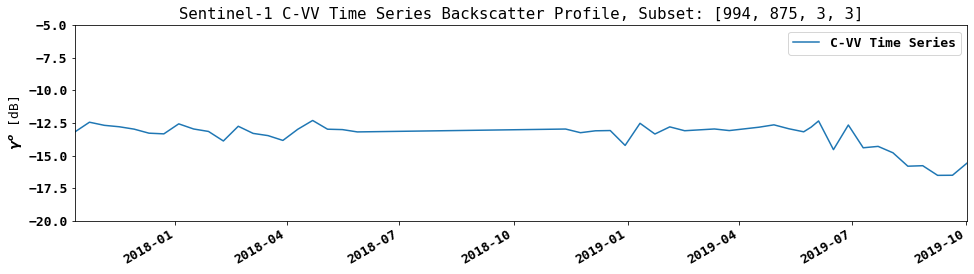

In [71]:
tsdf_sub1=tsdf[tsdf.index>'2017-10-01']

# Plot
tsdf_sub1.plot(figsize=(16,4))
plt.title('Sentinel-1 C-VV Time Series Backscatter Profile, Subset: {}'.format(subset))
plt.ylabel('$\gamma^o$ [dB]')
plt.ylim(ylim)
_=plt.legend(["C-VV Time Series"])

### Subset by months: 

Sometimes it is useful to subset a time series by certain months of a year, e.g. to avoid or target a rainy or frozen season.
We can make use of pandas DateTimeIndex object **index.month** and numpy's **logical_and** function to subset a time series easily by month.

####  March to May data only

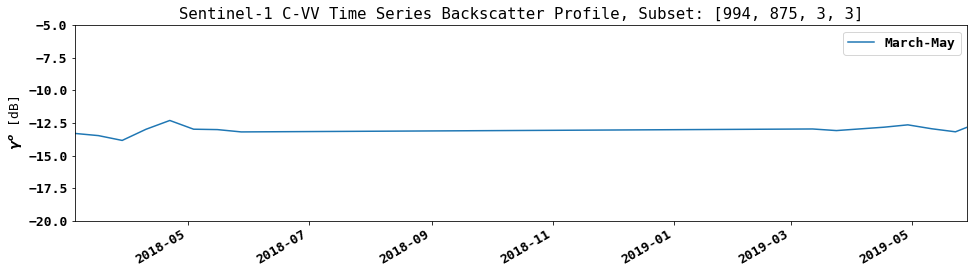

In [72]:
tsdf_sub2=tsdf_sub1[
    np.logical_and(tsdf_sub1.index.month>=3,tsdf_sub1.index.month<=5)]

# Plot
fig, ax = plt.subplots(figsize=(16,4))
tsdf_sub2.plot(ax=ax)
plt.title('Sentinel-1 C-VV Time Series Backscatter Profile, Subset: {}'
          .format(subset))
plt.ylabel('$\gamma^o$ [dB]')
plt.ylim(ylim)
_=plt.legend(["March-May"])

####  All other months
Using numpy's boolean **invert** function, we can invert a selection and in this example get to all other months:

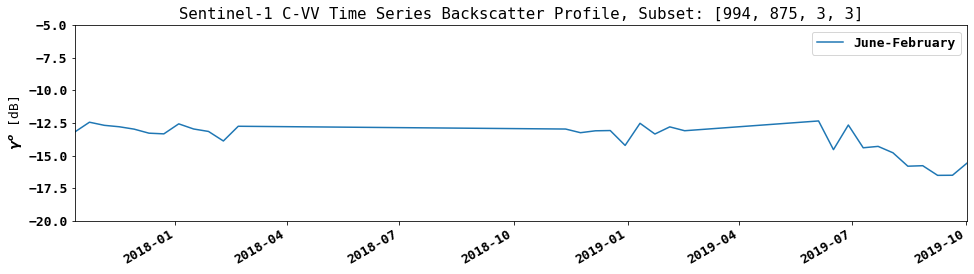

In [73]:
tsdf_sub3=tsdf_sub1[np.invert(
    np.logical_and(tsdf_sub1.index.month>=3,tsdf_sub1.index.month<=5))]

# Plot
fig, ax = plt.subplots(figsize=(16,4))
tsdf_sub3.plot(ax=ax)
plt.title('Sentinel-1 C-VV Time Series Backscatter Profile, Subset: {}'
          .format(subset))
plt.ylabel('$\gamma^o$ [dB]')
plt.ylim(ylim)
_=plt.legend(["June-February"])

###  Group time series by Year to compare average backscatter values
Another useful way to analyze time series is by comparing years in stacks. One might more readily discern whether in any give year the time series start to deviate from a previous year. We can easily group time series by years for this purpose.

In [74]:
ts_sub_by_year = tsdf_sub1.groupby(pd.Grouper(freq="Y"))

(-20, -5)

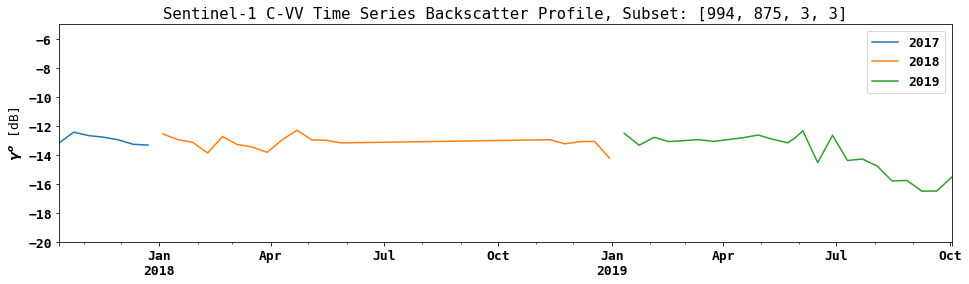

In [75]:
fig, ax = plt.subplots(figsize=(16,4))
for label, df in ts_sub_by_year:
    df.g0.plot(ax=ax, label=label.year)
plt.legend()
# ts_sub_by_year.plot(ax=ax)
plt.title('Sentinel-1 C-VV Time Series Backscatter Profile, Subset: {}'
          .format(subset))
plt.ylabel('$\gamma^o$ [dB]')
plt.ylim(ylim)


### Make a pivot table to group year and sort by day of year for plotting overlapping time series
First we add two coluns to the data frame:
- day of year (doy)
- year

In [76]:
# Add doy
tsdf_sub1 = tsdf_sub1.assign(doy=tsdf_sub1.index.dayofyear)
# Add year
tsdf_sub1 = tsdf_sub1.assign(year=tsdf_sub1.index.year)

Then a pivot table gets created which has day of year as the index and years as columns:

In [77]:
piv=pd.pivot_table(tsdf_sub1,index=['doy'],columns=['year'],values=['g0'])
# Set the names for the column indices
piv.columns.set_names(['g0','Year'],inplace=True) 
print(piv.head(10))
print('...\n',piv.tail(10))

g0     g0                      
Year 2017       2018       2019
doy                            
4     NaN -12.560661        NaN
11    NaN        NaN -12.518564
16    NaN -12.954243        NaN
23    NaN        NaN -13.339970
28    NaN -13.142223        NaN
35    NaN        NaN -12.792424
40    NaN -13.872442        NaN
47    NaN        NaN -13.087195
52    NaN -12.745283        NaN
64    NaN -13.291978        NaN
...
 g0           g0                
Year       2017       2018 2019
doy                            
309  -12.674030        NaN  NaN
316         NaN -12.958118  NaN
321  -12.783422        NaN  NaN
328         NaN -13.238367  NaN
333  -12.965023        NaN  NaN
340         NaN -13.093182  NaN
345  -13.275150        NaN  NaN
352         NaN -13.073409  NaN
357  -13.327437        NaN  NaN
364         NaN -14.211721  NaN


In [78]:
piv.columns.set_names(['g0','year'],inplace=True)

As we can see, there are NaN values on the days in a year where no acquisition took place. Now we use time weighted interpolation to fill the dates for all the observations in any given year. For **time weighted interpolation** to work we need to create a dummy year as a date index, perform the interplation, and reset the index to the day of year. This is accomplished with the following steps:

In [79]:
# Add fake dates for year 100 to enable time sensitive interpolation 
# of missing values in the pivot table
year_doy = ['2100-{}'.format(x) for x in piv.index]
y100_doy=pd.DatetimeIndex(pd.to_datetime(year_doy,format='%Y-%j'))

# make a copy of the piv table and add two columns
piv2=piv.copy()
piv2=piv2.assign(d100=y100_doy) # add the fake year dates
piv2=piv2.assign(doy=piv2.index) # add doy as a column to replace as index later again

# Set the index to the dummy year
piv2.set_index('d100',inplace=True,drop=True)

# PERFORM THE TIME WEIGHTED INTERPOLATION
piv2 = piv2.interpolate(method='time')  # TIME WEIGHTED INTERPOLATION!

# Set the index back to day of year.
piv2.set_index('doy',inplace=True,drop=True)

Let's inspect the new pivot table and see wheather we interpolated the NaN values where it made sense:

In [80]:
print(piv2.head(10))
print('...\n',piv2.tail(10))

g0     g0                      
year 2017       2018       2019
doy                            
4     NaN -12.560661        NaN
11    NaN -12.790250 -12.518564
16    NaN -12.954243 -12.860816
23    NaN -13.063898 -13.339970
28    NaN -13.142223 -13.111826
35    NaN -13.568184 -12.792424
40    NaN -13.872442 -12.915245
47    NaN -13.214933 -13.087195
52    NaN -12.745283 -13.059263
64    NaN -13.291978 -12.992225
...
 g0           g0                      
year       2017       2018       2019
doy                                  
309  -12.674030 -12.967298 -15.544156
316  -12.737842 -12.958118 -15.544156
321  -12.783422 -13.074888 -15.544156
328  -12.889356 -13.238367 -15.544156
333  -12.965023 -13.177873 -15.544156
340  -13.145930 -13.093182 -15.544156
345  -13.275150 -13.084943 -15.544156
352  -13.305651 -13.073409 -15.544156
357  -13.327437 -13.547706 -15.544156
364  -13.327437 -14.211721 -15.544156


Now we can plot the time series data with overlapping years 

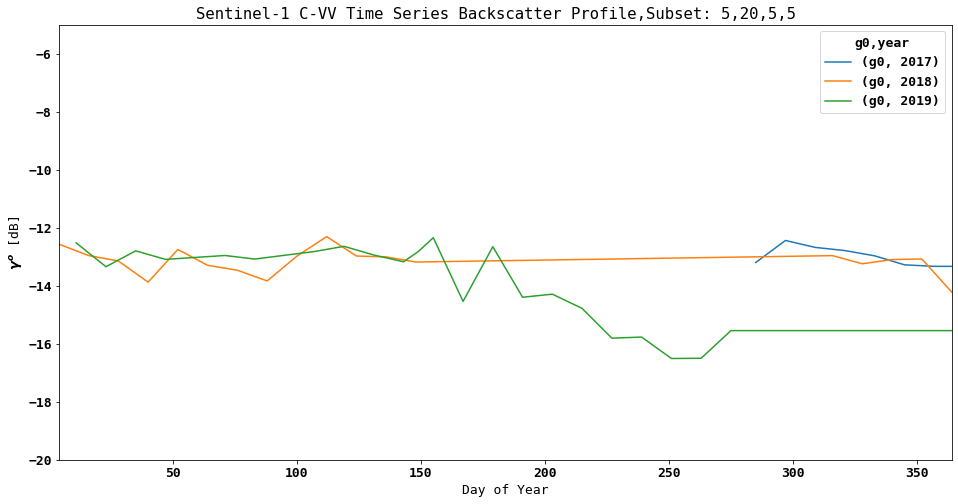

In [81]:
piv2.plot(figsize=(16,8))
plt.title('Sentinel-1 C-VV Time Series Backscatter Profile,\
Subset: 5,20,5,5  ')
plt.ylabel('$\gamma^o$ [dB]')
plt.xlabel('Day of Year')
_=plt.ylim(ylim)

# Change Detection on the Time Series Data
The goal being change detection we can now analyze the time series data for change. We will discuss two approaches:
1. Year-to-year differencing of the subsetted time series
2. Cumulative Sum based change detection

In [82]:
# Difference between years
# Set a dB change threshold
thres=3

In [83]:
diff1918 = (piv2.g0[2019] - piv2.g0[2018])

## Year-to-Year Change Detection

We compute the differences between the interpolated time series and look for change with a threshold value.

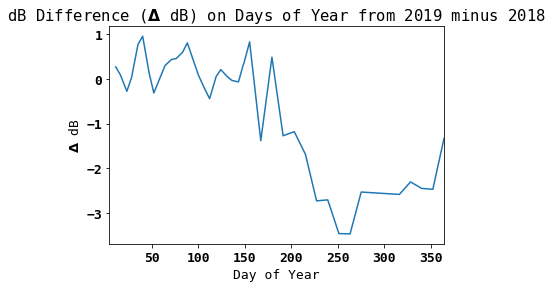

In [84]:
diff1918.plot(kind='line')
plt.ylabel('$\Delta$ dB')
plt.xlabel('Day of Year')
_=plt.title('dB Difference ($\Delta$ dB) on Days of Year from 2019 minus 2018')

In [85]:
thres_exceeded = diff1918[abs(diff1918) > thres]
print(thres_exceeded)

doy
251   -3.462124
263   -3.470261
dtype: float64


From the *three_exceeded* dataframe we can infer the first date at which the threshold was exeeded. We would label that as a change point. As an additional criteria for labeling a change point, one can also consider the number of observations after identification of a change point where backscatter differed from the year before. If only one or two observations differed from the year before this could be considered an outlier. Addtionally, one can introduce smoothing operations with the interpolation, e.g. a moving median.


### EXERCISE:
Work through the workbook again with selection of a different point and determine if it is a change point.



## Cumulative Sums for Change Detection
Another approach to detect change in regularly acquired data is employing cumulative sums. Changes are determined against mean observations of time series. A full explanation and examples from the the financial sector can be found at [http://www.variation.com/cpa/tech/changepoint.html](http://www.variation.com/cpa/tech/changepoint.html)

### Time Series and means
First let's consider a time series and it's mean observation. 
We look at two full years of observations from Sentinel-1 data for an area where we suspect change. In the following we consider $X$ as a time series

$X = (X_1,X_2,...,X_n)$

with

- $X_i$  SAR backscatter at time $i=1,...,n$
- $n$ number of observations in the time series

In [86]:
# Select a reference point
ref_point=12

In [87]:
# Get the corresponding subset in raster coordinates 
# and construct a time series
subset=get_subset(ref_point-1,ref_points)
ts1 = timeSeries(rasterstack_pwr,tindex2,subset)
X = ts1[ts1.index>'2017-10-31']
print('Ref.Point: {}, Raster Subset: {}'.format(ref_point,subset))

Ref.Point: 12, Raster Subset: [994, 875, 3, 3]


## Filtering the time series for outliers
It is advantagous in noisy  time series data like C-Band SAR data to filter  on the time axis. Pandas offers a "rolling" function for these purposes. With that function we can choose for example a median filter along the time axis. Below is an example of you a median filter for an observation filters the time series when the observation before and after a time stamps are part of the filter. 

 

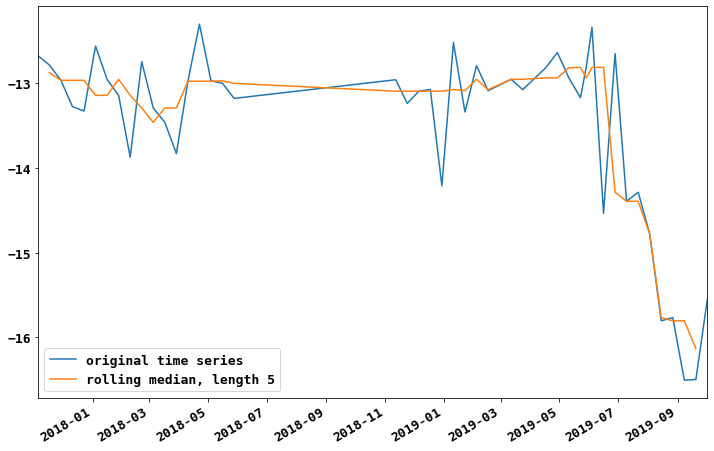

In [88]:
Xr5=X.rolling(5,center=True,min_periods=4).median()

plt.figure(figsize=(12,8))
X.plot(label='original time series')
Xr5.plot(label='rolling median, length 5')

_= plt.legend()

Let's plot the time series and it's mean over the time span for the smoothed time series with the rolling median length 5.

In [89]:
X=Xr5  # Uncomment if rolling mean is wanted for further computation
Xmean = 10*np.log10(10*np.power(10.,X/10.).mean()/10)

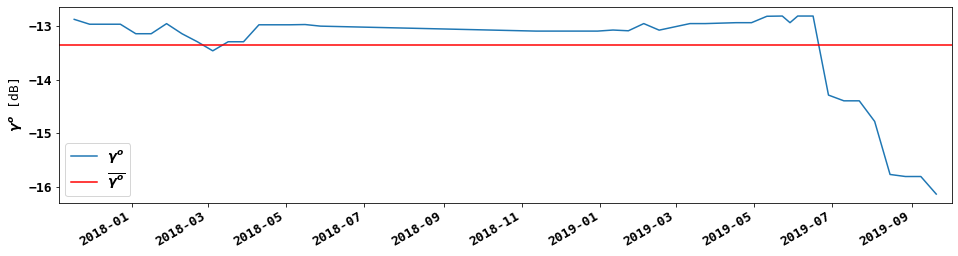

In [90]:
fig,ax=plt.subplots(figsize=(16,4))
X.plot()
plt.ylabel('$\gamma^o$ [dB]')
ax.axhline(Xmean,color='red')
_=plt.legend(['$\gamma^o$','$\overline{\gamma^o}$'])

Let's determind the residuals of the time series against the mean'

$R = X_i -\overline{X}$

In [91]:
R = X - Xmean

Now we compute the cumulative sum of the residuals and plot it:

$S = \displaystyle\sum_1^n{R_i}$

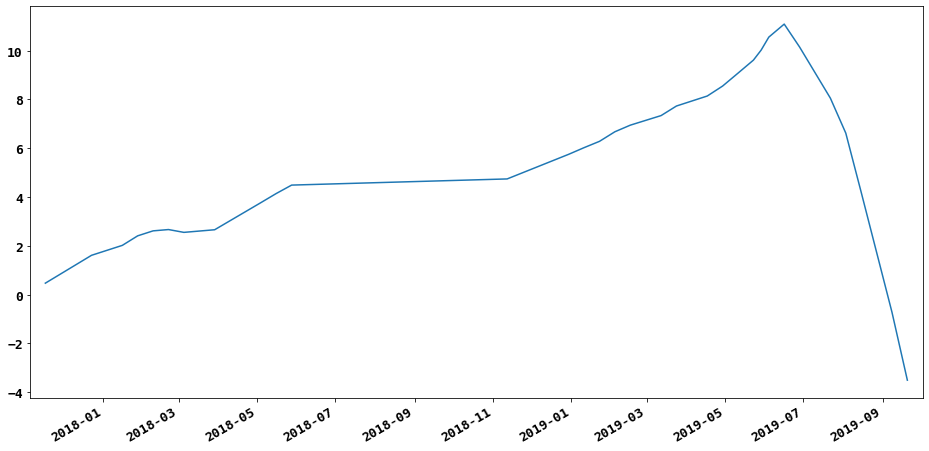

In [92]:
S = R.cumsum()

_=S.plot(figsize=(16,8))

An estimator for the magnitude of change is given as the difference between the maximum and minimum value of S

$S_{DIFF} = S_{MAX} - S_{MIN}$

In [93]:
Sdiff=S.max() - S.min()
Sdiff

14.593330785173636

A candidate change point is identified from the $S$ curve at the time where $S_{MAX}$ is found:

$T_{{CP}_{before}} = T(S_i = S_{MAX})$

with

- $T_{{CP}_{before}}$ Timestamp of last observation before change
- $S_i$    Cumulative Sum of R with $i=1,...n$
- $n$      Number of observations in the time series 

The first observation after change occured ($T_{{CP}_{after}}$) is then found as the first observation in the time series following $T_{{CP}_{before}}$.

For our example time series X these points are:

In [94]:
t_cp_before = S[S==S.max()].index[0]
print('Last date before change: {}'.format(t_cp_before.date()))

Last date before change: 2019-06-16


In [95]:
t_cp_after = S[S.index > t_cp_before].index[0]
print('First date after change: {}'.format(t_cp_after.date()))

First date after change: 2019-06-28


## Bootstrapping the cumulative sums by randomly reordering the time series

We can determine if an identified change point is indeed a valid detection by randomly reordring the time series and comparing the various S curves. During bootstrapping we count how many times the $S_{DIFF}$ values are greater than $S_{{DIFF}_{random}}$ of the identified change point. A confindence level $CL$ is computed as

$CL = \frac{N_{GT}}{N_{bootstraps}}$

with 

- $N_{GT}$    Number of times $S_{DIFF}$ > $S_{{DIFF}_{random}}$  
- $N_{bootstraps}$    Number of bootstraps randomizing $R$

Another metric for the significance of a change point is 1 minus the ratio of the mean of the $S_{{DIFF}_{random}}$ values and $S_{DIFF}$. The closer this value is approaching 1, the more significant the change point: 

$CP_{significance} = 1 - \left( \frac{\sum_{b=1}^{N_{bootstraps}}{S_{{DIFF}_{{random}_i}}}}{N_{bootstraps}} \middle/ S_{DIFF} \right)$

The python code to conduct the boot strapping, including visualization of the S curves is below:

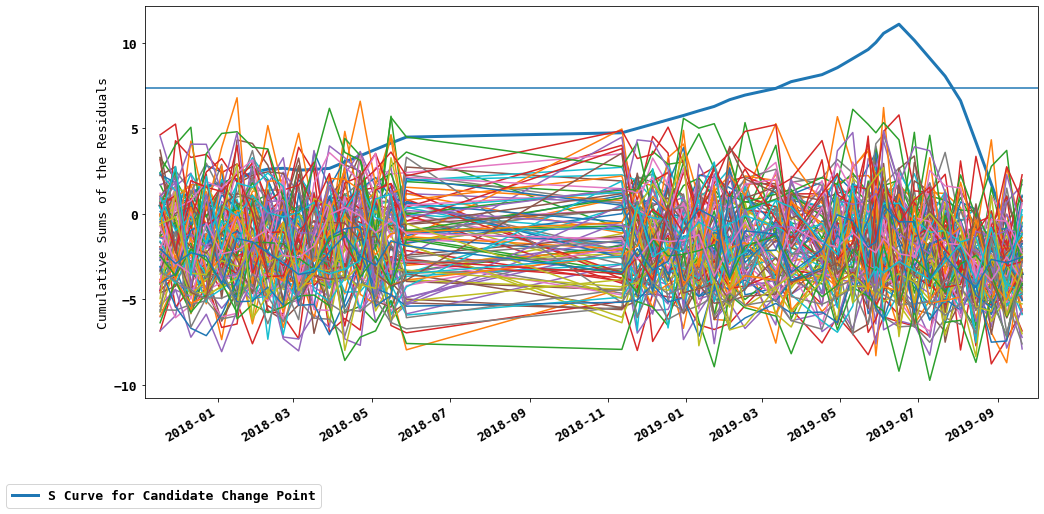

In [96]:
n_bootstraps=100  # bootstrap sample size
fig,ax = plt.subplots(figsize=(16,8))
S.plot(ax=ax,linewidth=3)
ax.set_ylabel('Cumulative Sums of the Residuals')
fig.legend(['S Curve for Candidate Change Point'],loc=3)
Sdiff_random_sum=0
Sdiff_random_max=0  # to keep track of the maxium Sdiff of the 
               # bootstrapped sample
n_Sdiff_gt_Sdiff_random=0  # to keep track of the maxium Sdiff of the 
               # bootstrapped sample
for i in range(n_bootstraps):
    Rrandom = R.sample(frac=1)  # Randomize the time steps of the residuals
    Srandom = Rrandom.cumsum()
    Sdiff_random=Srandom.max()-Srandom.min()
    Sdiff_random_sum += Sdiff_random
    if Sdiff_random > Sdiff_random_max:
        Sdiff_random_max = Sdiff_random
    if Sdiff > Sdiff_random:
        n_Sdiff_gt_Sdiff_random += 1
    Srandom.plot(ax=ax)
_=ax.axhline(Sdiff_random_sum/n_bootstraps)

In [97]:
CL = 1.*n_Sdiff_gt_Sdiff_random/n_bootstraps
print('Confidence Level for change point {} percent'.format(CL*100.))

Confidence Level for change point 100.0 percent


In [98]:
CP_significance = 1. - (Sdiff_random_sum/n_bootstraps)/Sdiff 
print('Change point significance metric: {}'.format(CP_significance))

Change point significance metric: 0.4963674419293759


Another useful metric to determine strength of a change point is the normalized integral $S_{ni}$ of the absolute values of the S curve:

$S_{normintegral} = \frac{\int_{i=1}^n \frac{abs(S_i)}{\max{abs(S)}} } {n}$

In [99]:
# NaN's to be excluded in the computation 
S_ni=(S.abs()/S.abs().max()).cumsum().max()/len(S[S != np.nan])
print('Normalized Integral of cumulative sum: {}'.format(S_ni))

Normalized Integral of cumulative sum: 0.4423823151668663


### EXERCISE
Conduct the change point analysis for different subsets in the traning data, e.g. points 4, 26, 27

## Selection of threshold values
$CL$ and $CP_{significance}$ can be used as threshold values for the acceptance or rejection of a candidate threshold. These values are to some degree specific to a SAR sensor and environmental conditions. E.g. L-Band SAR has a more pronounced decrease in backscatter after forest disturbance and logging, whereas C-Band can have more ambigious signals. Also moisture regime changes, e.g. with snow cover, freeze/thaw conditions or dry/wet season changes have an influence on the time series signal. For example El Nino years can suggest changes solely due to different wetting and dryup conditions pertinent to a particular year. For this reason other techniques  can be added to the SAR time series ananlysis. Two techniques can readily be thought of:

- Subsetting of time series by seasons
- Detrending time series with global image means

If year-to-year comparison is the focus, the first approach likely leads to subsets that are too small for meaningful cumulative sum change point detection. The approach of interannual differencing as discussed above likely performs better.


In the following we explore the approach to detrend the data with global image means.

### De-trending time series with global image means
The idea of de-trending time series with global image meams should prepare time series for a somewhat robuster change point detection as global image time series anomalies stemming calibration or seasonal trends are removed prior to time series analysis. This de-trending needs to be performed with large subsets so real change is not influencing the image statistics. 

NOTE: For our small subset, we will see  some of these effects.

Let's start by building a global image means time series:

In [100]:
means_pwr = np.mean(rasterstack_pwr,axis=(1,2))
means_dB = 10.*np.log10(means_pwr)
gm_ts = pd.Series(means_dB,index=tindex2)
gm_ts=gm_ts[gm_ts.index > '2017-10-31']  # filter dates
gm_ts=gm_ts.rolling(5,center=True).median()

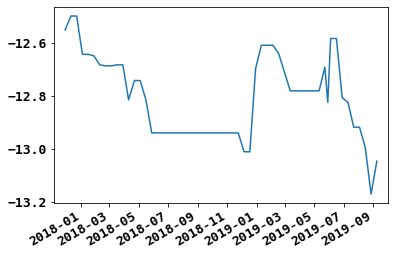

In [101]:
gm_ts.plot()

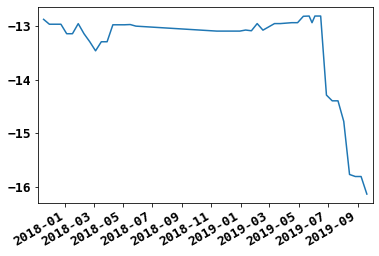

In [102]:
X.plot()

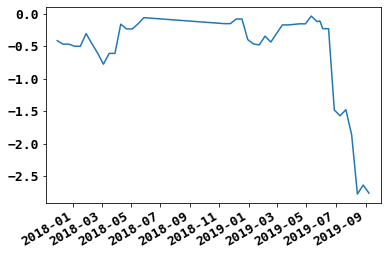

In [103]:
Xd=X-gm_ts
Xmean=Xd.mean()
Xd.plot()

In [104]:
R = Xd - Xmean

Now we compute the cumulative sum of the residuals and plot it:

$S = \displaystyle\sum_1^n{R_i}$

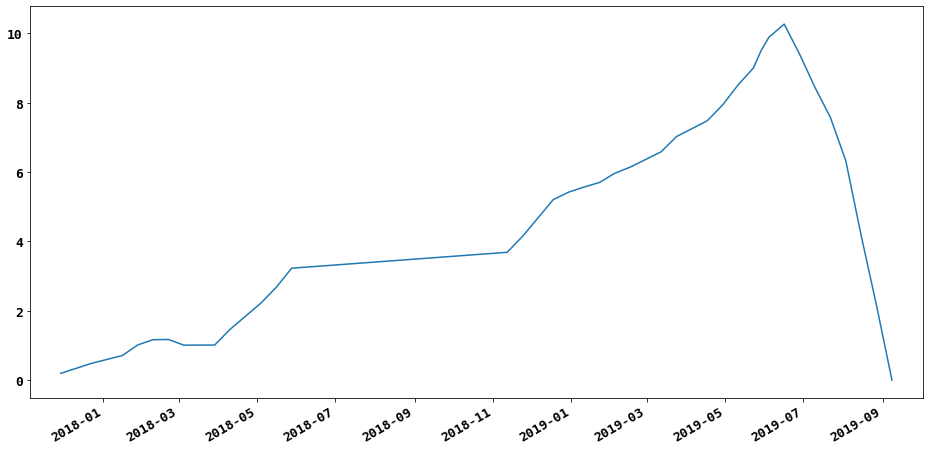

In [105]:
S = R.cumsum()

_=S.plot(figsize=(16,8))

An estimator for the magnitude of change is given as the difference between the maximum and minimum value of S

$S_{DIFF} = S_{MAX} - S_{MIN}$

In [106]:
Sdiff=S.max() - S.min()
Sdiff

10.262638464613676

A candidate change point is identified from the $S$ curve at the time where $S_{MAX}$ is found:

$T_{{CP}_{before}} = T(S_i = S_{MAX})$

with

- $T_{{CP}_{before}}$ Timestamp of last observation before change
- $S_i$    Cumulative Sum of R with $i=1,...n$
- $n$      Number of observations in the time series 

The first observation after change occured ($T_{{CP}_{after}}$) is then found as the first observation in the time series following $T_{{CP}_{before}}$.

For our example time series X these points are:

In [107]:
t_cp_before = S[S==S.max()].index[0]
print('Last date before change: {}'.format(t_cp_before.date()))

Last date before change: 2019-06-16


In [108]:
t_cp_after = S[S.index > t_cp_before].index[0]
print('First date after change: {}'.format(t_cp_after.date()))

First date after change: 2019-06-28


## Bootstrapping the cumulative sums by randomly reordering the time series

We can determine if an identified change point is indeed a valid detection by randomly reordring the time series and comparing the various S curves. During bootstrapping we count how many times the $S_{DIFF}$ values are greater than $S_{{DIFF}_{random}}$ of the identified change point. A confindence level $CL$ is computed as

$CL = \frac{N_{GT}}{N_{bootstraps}}$

with 

- $N_{GT}$    Number of times $S_{DIFF}$ > $S_{{DIFF}_{random}}$  
- $N_{bootstraps}$    Number of bootstraps randomizing $R$

Another metric for the significance of a change point is 1 minus the ratio of the mean of the $S_{{DIFF}_{random}}$ values and $S_{DIFF}$. The closer this value is approaching 1, the more significant the change point: 

$CP_{significance} = 1 - \left( \frac{\sum_{b=1}^{N_{bootstraps}}{S_{{DIFF}_{{random}_i}}}}{N_{bootstraps}} \middle/ S_{DIFF} \right)$

The python code to conduct the boot strapping, including visualization of the S curves is below:

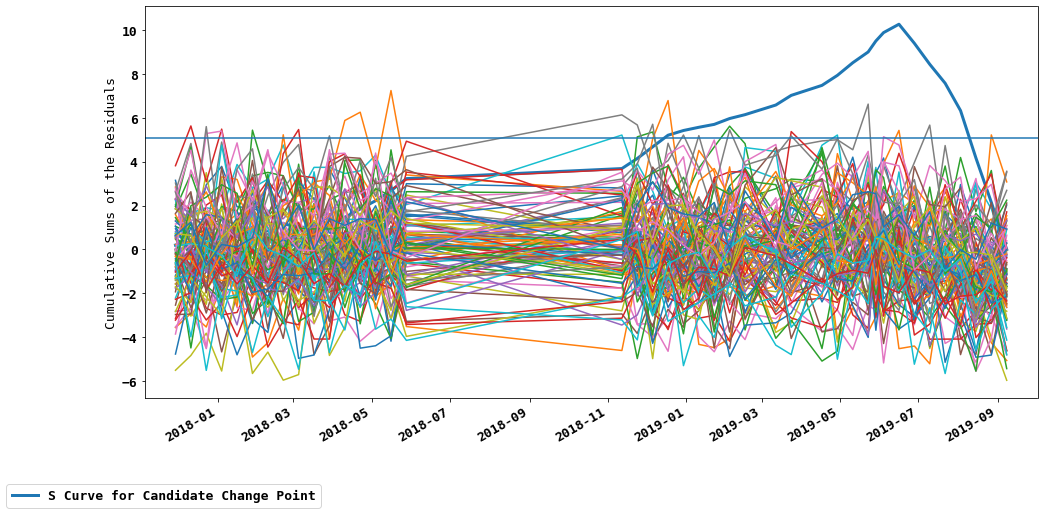

In [109]:
n_bootstraps=100  # bootstrap sample size
fig,ax = plt.subplots(figsize=(16,8))
S.plot(ax=ax,linewidth=3)
ax.set_ylabel('Cumulative Sums of the Residuals')
fig.legend(['S Curve for Candidate Change Point'],loc=3)
Sdiff_random_sum=0
Sdiff_random_max=0  # to keep track of the maxium Sdiff of the 
               # bootstrapped sample
n_Sdiff_gt_Sdiff_random=0  # to keep track of the maxium Sdiff of the 
               # bootstrapped sample
for i in range(n_bootstraps):
    Rrandom = R.sample(frac=1)  # Randomize the time steps of the residuals
    Srandom = Rrandom.cumsum()
    Sdiff_random=Srandom.max()-Srandom.min()
    Sdiff_random_sum += Sdiff_random
    if Sdiff_random > Sdiff_random_max:
        Sdiff_random_max = Sdiff_random
    if Sdiff > Sdiff_random:
        n_Sdiff_gt_Sdiff_random += 1
    Srandom.plot(ax=ax)
_=ax.axhline(Sdiff_random_sum/n_bootstraps)

In [110]:
CL = n_Sdiff_gt_Sdiff_random/n_bootstraps
print('Confidence Level for change point {} percent'.format(CL*100.))

Confidence Level for change point 100.0 percent


In [111]:
CP_significance = 1. - (Sdiff_random_sum/n_bootstraps)/Sdiff 
print('Change point significance metric: {}'.format(CP_significance))

Change point significance metric: 0.5061809258474956


Another useful metric to determine strength of a change point is the normalized integral $S_{ni}$ of the absolute values of the S curve:

$S_{normintegral} = \frac{\int_{i=1}^n \frac{abs(S_i)}{\max{abs(S)}} } {n}$

In [112]:
S_ni=(S.abs()/S.abs().max()).cumsum().max()/len(S[S != np.nan])
print('Normalized Integral of cumulative sum: {}'.format(S_ni))

Normalized Integral of cumulative sum: 0.3916181807552158


## Cumulative Sum Change Detection for the entire image
With numpy arrays we can apply the concept of cumulative sum change detection analysis effectively on the entire image stacke. We take advantage of array slicing and axis-based computing in numpy. axis 0 is the time time domain in out raster stacks

In [113]:
src_img=gdal.Open(imagefile)
geotrans=src_img.GetGeoTransform()
ulx,uly=370619.736,9337000.785
xoff,yoff=XY_to_PixelLine(ulx,uly,geotrans)
xsize,ysize=200,200
subset=(xoff,yoff,xsize,ysize)
print(subset)

(1031, 800, 200, 200)


In [114]:
rasterstack_amp = src_img.ReadAsArray(*subset)
rasterstack_amp = np.vstack((rasterstack_amp[:39],rasterstack_amp[41:])) ## COMMENT OR ADJUST FOR OTHER LAYERS
rasterstack_pwr = np.power(rasterstack_amp,2.)*calPwr
rasterstack_pwr.shape

(67, 200, 200)

In [115]:
# Test this also in the dB scale We'll work in the dB scale
# xoff,yoff,xsize,ysize=[800,600,200,200]
# X = rasterstack_pwr[:,yoff:(yoff+ysize),xoff:(xoff+xsize)]
X = rasterstack_pwr
# Filter out the first layer ( Dates >= '2015-11-1')
X_sub=X[:,:,:]
tindex_sub=tindex[:]
X= 10.*np.log10(X_sub)  # Uncomment to work in dB Scale

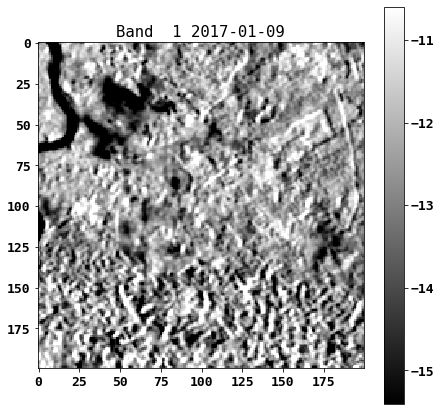

In [116]:
plt.figure(figsize=(7.3,7.3))
bandnbr=0
vmin=np.percentile(X[bandnbr],5)
vmax=np.percentile(X[bandnbr],95)
plt.title('Band  {} {}'.format(bandnbr+1,tindex_sub[bandnbr].date()))
plt.imshow(X[0],cmap='gray',vmin=vmin,vmax=vmax)
_=plt.colorbar()

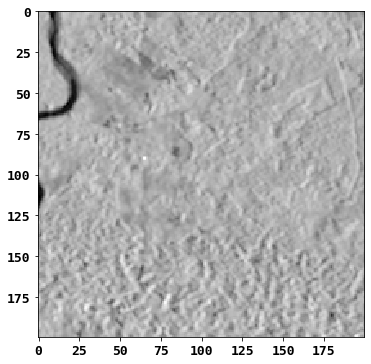

In [117]:
Xmean=np.mean(X,axis=0)
plt.figure(figsize=(6,6))
plt.imshow(Xmean,cmap='gray')

In [118]:
X.shape

(67, 200, 200)

In [119]:
R=X-Xmean

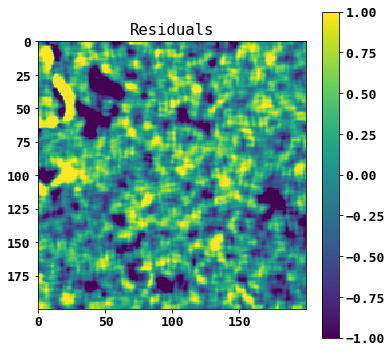

In [120]:
plt.figure(figsize=(6,6))
plt.imshow(R[0],vmin=-1,vmax=1)
plt.title('Residuals')
_=plt.colorbar()


In [121]:
np.percentile(Sdiff,(95,5))

array([10.26263846, 10.26263846])

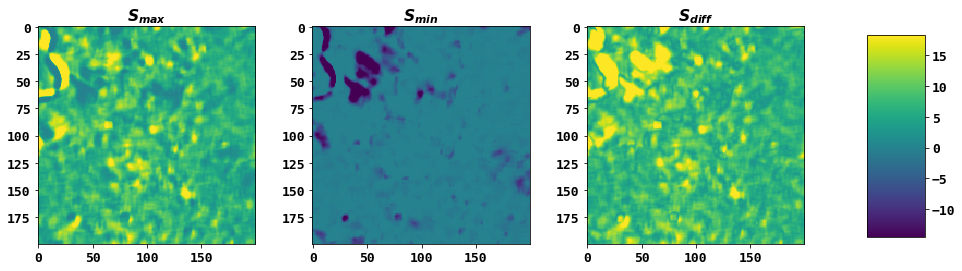

In [122]:
S = np.cumsum(R,axis=0)
Smax= np.max(S,axis=0)
Smin= np.min(S,axis=0)
Sdiff=Smax-Smin
fig,ax=plt.subplots(1,3,figsize=(16,4))
vmin=np.percentile(Smin,(2))
vmax=np.percentile(Smax,(98))
# vmin=Smin.min()
# vmax=Smax.max()
p=ax[0].imshow(Smax,vmin=vmin,vmax=vmax)
ax[0].set_title('$S_{max}$')
ax[1].imshow(Smin,vmin=vmin,vmax=vmax)
ax[1].set_title('$S_{min}$')
ax[2].imshow(Sdiff,vmin=vmin,vmax=vmax)
ax[2].set_title('$S_{diff}$')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
_=fig.colorbar(p,cax=cbar_ax)

## Mask Sdiff with a priori threshold for expected change
If we have an assumption as to how much actual change we expect in the image, we can threshold $S_{diff}$ to reduce computiation of the bootstrapping. For land cover chaangem we would not expect more than 5-10% change in a landscape. So, if the test region is reasonably large, setting a threshold for expected change to 10% would be appropriate. Thus we can set a mask with the 90th percentile of the histogram of $S_{diff}$. In our example we'll start out with a very conservative threshold of 20%, because we also only work on a small subset where we tried to find more change.

The histogram for $S_{diff}$ is shown below.



At the 20% percentile, the threshold value is 19.31


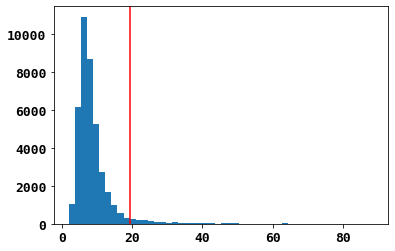

In [123]:
precentile=20
fig,ax=plt.subplots()
h=ax.hist(Sdiff.flatten(),bins=50)
thres=np.percentile(h[1],precentile)
print('At the {}% percentile, the threshold value is {:2.2f}'.format(precentile,thres))
_=ax.axvline(thres,color='red')

At the 20% percentile, the threshold value is

Using this threshold, we can visualize the candidate changpoints:

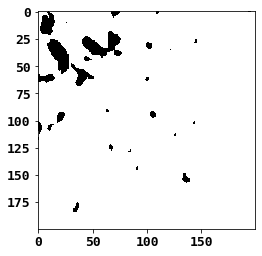

In [124]:
Sdiffmask=Sdiff<thres
_=plt.imshow(Sdiffmask,cmap='gray')

Now we can filter our Residuals and perform bootstrapping analysis on these data. We make use of numpy masekd arrays for this purpose.


In [125]:
Rmask = np.broadcast_to(Sdiffmask,R.shape)

In [126]:
Rmasked = np.ma.array(R,mask=Rmask)

On the masked time series stack of residuals we can computed the cumulative sums:

In [127]:
Smasked = np.ma.cumsum(Rmasked,axis=0)

$S_{MAX}$, $S_{MIN}$, $S_{DIFF}$ can also be computed on the masked arrays :

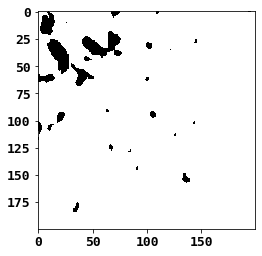

In [128]:
plt.imshow(Rmasked.mask[0],cmap='gray')

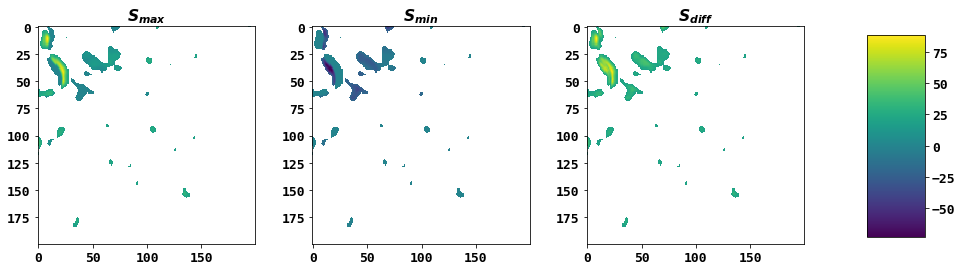

In [129]:
Smasked = np.ma.cumsum(Rmasked,axis=0)
Smasked_max= np.ma.max(Smasked,axis=0)
Smasked_min= np.ma.min(Smasked,axis=0)
Smasked_diff=Smasked_max-Smasked_min
fig,ax=plt.subplots(1,3,figsize=(16,4))
vmin=Smasked_min.min()
vmax=Smasked_max.max()
p=ax[0].imshow(Smasked_max,vmin=vmin,vmax=vmax)
ax[0].set_title('$S_{max}$')
ax[1].imshow(Smasked_min,vmin=vmin,vmax=vmax)
ax[1].set_title('$S_{min}$')
ax[2].imshow(Smasked_diff,vmin=vmin,vmax=vmax)
ax[2].set_title('$S_{diff}$')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
_=fig.colorbar(p,cax=cbar_ax)



## Bootstrapping over the masked change point candidates
We can now perform the bootstrapping analysis over the not masked out values. For efficient computing we permutate the index of the time axis.

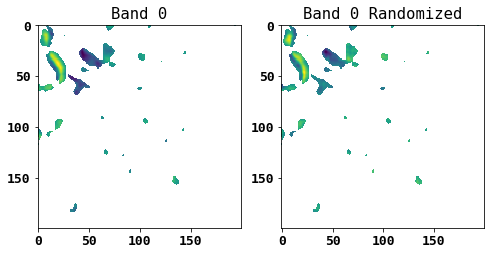

In [130]:
random_index=np.random.permutation(Rmasked.shape[0])
Rrandom=Rmasked[random_index,:,:]

fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(Rmasked[0])
ax[0].set_title('Band 0')
ax[1].imshow(Rrandom[0])
_=ax[1].set_title('Band 0 Randomized')


In [131]:
Smasked_max=np.ma.max(Smasked,axis=0)

Below is the numpy based implementation of the bootstrapping over all pixels. Note the efficient implementation using nympy masked arrays.

In [132]:
n_bootstraps=100  # bootstrap sample size

# to keep track of the maxium Sdiff of the bootstrapped sample:
Sdiff_random_max = np.ma.copy(Smasked_diff) 
Sdiff_random_max[~Sdiff_random_max.mask]=0
# to compute the Sdiff sums of the bootstrapped sample:
Sdiff_random_sum = np.ma.copy(Smasked_diff) 
Sdiff_random_sum[~Sdiff_random_max.mask]=0
# to keep track of the count of the bootstrapped sample
n_Sdiff_gt_Sdiff_random = np.ma.copy(Smasked_diff) 
n_Sdiff_gt_Sdiff_random[~n_Sdiff_gt_Sdiff_random.mask]=0
for i in range(n_bootstraps):
    # For efficiency, we shuffle the time axis index and use that 
    #to randomize the masked array
    random_index=np.random.permutation(Rmasked.shape[0])
    # Randomize the time step of the residuals
    Rrandom = Rmasked[random_index,:,:]  
    Srandom = np.ma.cumsum(Rrandom,axis=0)
    Srandom_max=np.ma.max(Srandom,axis=0)
    Srandom_min=np.ma.min(Srandom,axis=0)
    Sdiff_random=Srandom_max-Srandom_min
    Sdiff_random_sum += Sdiff_random
    Sdiff_random_max[np.ma.greater(Sdiff_random,Sdiff_random_max)]=\
    Sdiff_random[np.ma.greater(Sdiff_random,Sdiff_random_max)]
    n_Sdiff_gt_Sdiff_random[np.ma.greater(Smasked_diff,Sdiff_random)] += 1

Now we can compute for all pixels the confidence level $CL$, the change point significance metric $CP_{significance} and the product of the two as our confidence metric for identified changepoints.

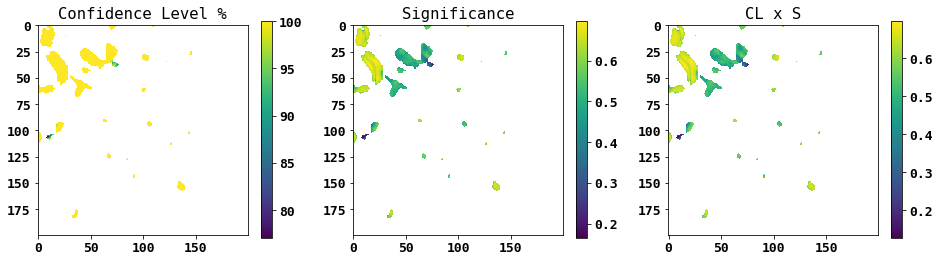

In [133]:
CL = n_Sdiff_gt_Sdiff_random/n_bootstraps
CP_significance = 1.- (Sdiff_random_sum/n_bootstraps)/Sdiff 
#Plot
fig,ax=plt.subplots(1,3,figsize=(16,4))
a = ax[0].imshow(CL*100)
fig.colorbar(a,ax=ax[0])
ax[0].set_title('Confidence Level %')
a = ax[1].imshow(CP_significance)
fig.colorbar(a,ax=ax[1])
ax[1].set_title('Significance')
a = ax[2].imshow(CL*CP_significance)
fig.colorbar(a,ax=ax[2])
_=ax[2].set_title('CL x S')

Now if we were to set a threshold of 0.5 for the product as identified change our change map would look like the following figure:


In [134]:
cp_thres=0.4

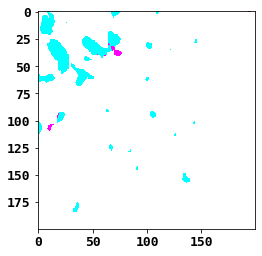

In [135]:
plt.imshow(CL*CP_significance <  cp_thres,cmap='cool')

Our last step is the idenficiaton of the change points is to extract the timing of the change. We will produce a raster layer that shows the band number of this first date after detected change. We will make use of the numpy indexing scheme. First, we create a combined mask of the first threshold and the identified change points after the bootstrapping. For this we use the numpy "mask_or" operation.


In [136]:
# make a mask of our change points from the new threhold and the previous 
# mask
cp_mask=np.ma.mask_or(CL*CP_significance<cp_thres,CL.mask)
# Broadcast the mask to the shape of the masked S curves
cp_mask2 = np.broadcast_to(cp_mask,Smasked.shape)
# Make a numpy masked array with this mask
CPraster = np.ma.array(Smasked.data,mask=cp_mask2)

To retrieve the dates of the change points we find the band indices in the time series along the time axis where the the maximum of the cumulative sums was located. Numpy offers the "argmax" function for this purpose.

In [137]:
CP_index= np.ma.argmax(CPraster,axis=0)
change_indices = list(np.unique(CP_index))
change_indices.remove(0)
print(change_indices)
# Look up the dates from the indices to get the change dates
alldates=tindex[tindex>'2015-10-31']
change_dates=[str(alldates[x+1].date()) for x in change_indices]
print(change_dates)

[1, 2, 3, 4, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 45, 47, 48, 49, 52, 56, 60, 61, 64, 65, 66]
['2017-02-26', '2017-03-10', '2017-04-03', '2017-04-15', '2017-06-02', '2017-06-14', '2017-06-26', '2017-07-08', '2017-07-20', '2017-08-01', '2017-08-13', '2017-08-25', '2017-09-18', '2017-09-30', '2017-10-12', '2017-10-24', '2017-11-05', '2017-11-17', '2017-11-29', '2017-12-11', '2017-12-23', '2018-01-04', '2018-01-16', '2018-01-28', '2018-02-09', '2018-02-21', '2018-03-05', '2018-03-17', '2018-03-29', '2018-04-10', '2018-04-22', '2018-05-04', '2018-05-16', '2018-05-28', '2018-06-09', '2018-11-12', '2018-11-24', '2018-12-30', '2019-01-23', '2019-02-04', '2019-02-16', '2019-04-17', '2019-05-29', '2019-07-10', '2019-07-22', '2019-08-27', '2019-09-08', '2019-09-20']


Lastly, we visualize the change dates by showing the CP_index raster and label the change dates.

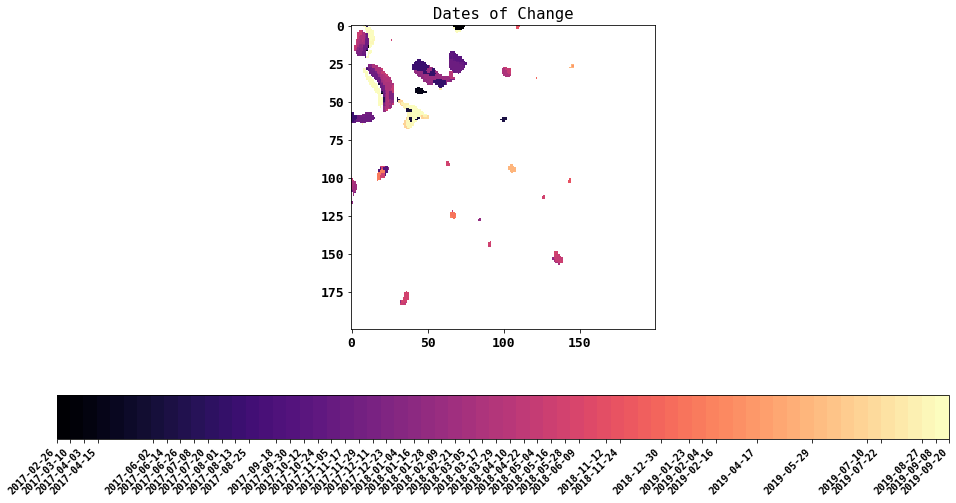

In [138]:
ticks=change_indices
ticklabels=change_dates
CP_index_masked=np.ma.array(CP_index,mask=CP_index==0)
cmap=plt.cm.get_cmap('magma',ticks[-1])
fig, ax = plt.subplots(figsize=(16,8))
cax = ax.imshow(CP_index_masked,interpolation='nearest',cmap=cmap)
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(p,cax=cbar_ax)

ax.set_title('Dates of Change')
# cbar = fig.colorbar(cax,ticks=ticks)
cbar=fig.colorbar(cax,ticks=ticks,orientation='horizontal')
_=cbar.ax.set_xticklabels(ticklabels,size=10,rotation=45,ha='right')  

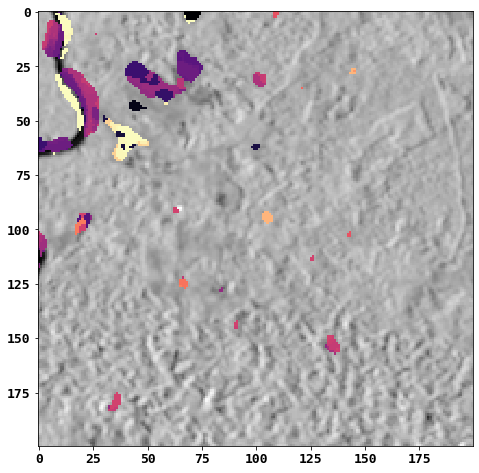

In [139]:
plt.figure(figsize=(8,8))
plt.imshow(Xmean,cmap='gray')
plt.imshow(CP_index_masked,cmap=cmap)

In [140]:
# Create output Image
drv=gdal.GetDriverByName('GTiff')
img = drv.Create('cp.tif',CP_index.shape[1],CP_index.shape[0],1,gdal.GDT_Byte,options=['COMPRESS=LZW'])
img.SetProjection(proj)
geotrans=list(gdal.Open(imagefile).GetGeoTransform())
cp_geotrans=geotrans
cp_geotrans[0]=geotrans[0]+subset[0]*geotrans[1]
cp_geotrans[3]=geotrans[3]+subset[1]*geotrans[5]
img.SetGeoTransform(cp_geotrans)
img.SetDescription('SAR Fun with Josef: Change Points '+flightdirection_polarization)
# Write the data
band=img.GetRasterBand(1)
band.WriteArray(CP_index)
# Write a Color lookup table
colors = gdal.ColorTable()
for i in range(len(change_indices)):
    # set color for each value
#     print(tuple([int(round(x*255)) for x in cmap.colors[i][:3]]))
    colors.SetColorEntry(int(change_indices[i]),tuple([int(round(x*255))\
                                                       for x in cmap.colors[change_indices[i]-1][:3]]))
# set color table and color interpretation
band.SetRasterColorTable(colors)
band.SetRasterColorInterpretation(gdal.GCI_PaletteIndex)
# Set no data value
band.SetNoDataValue(0)
# Close
band=None
img=None

## Secondary Change Points
After detection of a change point in the time series we can split the series in before and after change subsets. For forest degradation or deforestation detection for example this could apply when over the course of a multi-year time series selective logging preceeds a clearing event or converion of a logged plot to agriculture or regrowth, which show typically different time series profiles of radar backscatter. The approach to detect secondary change points would be to repeat analysis of the time series split into before and after change point detection. 

## Considerations for Forest Masking

After having detected all change points, there are several approaches to further filter the masks for areas that are only concerning one land cover type, e.g. forests. For forests we can observe for example that the backscatter time series are rather smooth before disturbance with slight dependencies on moisture regimes. This is also dependent on what SAR wavelength is used. L-Band tends to be smoother and more pronounced change from logging. 

In order to filter change points to forest change one could:
- Apply a forest/non-forest mask, e.g. from the previous year
- Determine the smoothness of a time series before detected change (assuming a referecene period is available). Use COV or variance for that determination
- Classify imagery by absolute backscatter values or means before a change. Low backscatter is typically not associated with forest.



